In [346]:
library(dplyr)
library(tibble)
library(tidyr)
library(umap)
library(rgl)
library(xtable)

library(RColorBrewer)
library(ggplot2)
library(cowplot)
theme_set(theme_bw())

In [2]:
options(repr.plot.width = 8, repr.plot.height = 4)

In [375]:
# source files
src_files <- list.files('../R', full.names = TRUE)
for (f in src_files) {
  source(f)
  cat(sprintf('Sourced file: %s\n', f))
}

Sourced file: ../R/batch.R
Sourced file: ../R/calc.R
Sourced file: ../R/misc.R
Sourced file: ../R/normalise.R
Sourced file: ../R/plot.R
Sourced file: ../R/predict.R
Sourced file: ../R/subset.R
Sourced file: ../R/utils.R


## Import data

In [4]:
# Metadata
METADATA_SID <- "../data/GSE67684/processed/metadata/sid-metadata_v2.tsv"
METADATA_PID <- "../data/GSE67684/processed/metadata/pid-metadata_v7.tsv"
metadata_sid <- read.table(METADATA_SID, sep = "\t")
metadata_pid <- read.table(METADATA_PID, sep = "\t", row.names = 1, quote = '"')

## Data
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "../data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")

In [5]:
# Metadata
metadata_sid$label <- as.factor(metadata_sid$label)
levels(metadata_sid$label) <- c('Remission', 'Relapse')
metadata_sid$batch_info <- as.factor(metadata_sid$batch_info) 
metadata_pid$label <- as.factor(metadata_pid$label)
levels(metadata_pid$label) <- c('Remission', 'Relapse')

# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
yeoh <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_sid))

# All features
yeoh_allps <- log2_transform(scaled_yeoh)
yeoh_unfltr <- log2_transform(selected_yeoh)

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] "No. of probesets removed = 6321"


### Commonly used globals

#### All train set (incl. hyperdiploid, others)
- For feature investigation. Remove hypodiploid
- Not required in code!

#### All train set (excl. hyperdiploid, others)
- Does not contain heterogeneous subtypes and MRD NA samples

#### Train/test split (excl. hyperdiploid, others)
- Test set does not contain heterogeneous subtypes and MRD NA samples
- Training set should have the same distribution as test set

In [484]:
### GLOBAL VARIABLES
metadata <- metadata_sid[colnames(yeoh),]

heatmap_metadata <- metadata[, c("batch_info", "label"), drop = F]
COL_LABEL <- c("darkolivegreen3", "tomato3")
names(COL_LABEL) <- c('Remission', 'Relapse')

# List subtypes
subtypes9 <- levels(metadata_sid$subtype)
subtypes7 <- setdiff(subtypes9, c("Hypodiploid", "Normal"))
subtypes6 <- setdiff(subtypes7, "Others")
subtypes5 <- setdiff(
  subtypes9,
  c("Hypodiploid", "Normal", "Hyperdiploid", "Others")
)
others <- yeoh[, metadata$subtype == "Others"]
others_normal <- yeoh[, metadata$subtype %in% c("Others", "Normal")]

# Define train/test split
sid_mrd_na <- rownames(metadata_pid)[is.na(metadata_pid$d33_mrd)] %>%
  rep(each = 2) %>%
  paste0(c("_D0", "_D8"))

sid_alltrain_local <- rownames(metadata)[
  !(metadata$subtype %in% c("Hypodiploid", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_alltrain <- rownames(metadata)[
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_train <- rownames(metadata)[
  metadata$batch_info %in% 1:7 &
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_test <- rownames(metadata)[
  metadata$batch_info %in% 8:10 &
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]

sid_remission <- rownames(metadata)[metadata$label == 'Remission']
sid_normal <- paste0("N0", c(1,2,4))

# Plot
metadata_plot <- metadata
colnames(metadata_plot) <- c('Batch', 'Class', 'Subtype', 'Outcome')

### PCA

In [314]:
# ggplot_pca(yeoh, metadata, col = 'batch_info')
# ggplot_pca(yeoh, metadata, col = 'batch_info', x = 'PC3', y = 'PC2')

In [354]:
# plot3d_yeoh(
#   yeoh, metadata_sid,
#   width = 600, height = 500,
#   cex = .4, lwd = .5
# )
# rgl.viewpoint(theta = 40, phi = -30, zoom = 1)
# rgl.postscript('~/Dropbox/tmp/pca.pdf', fmt = 'pdf')

[1] "PCA performed!"


### Train/test split: Patients distribution

In [14]:
# # TODO: Do not evaluate to heterogeneous subtypes
# train_distr <- table(
#   Y[sid_train, "subtype"],
#   Y[sid_train, "label"]
# )/2
# test_distr <- table(
#   Y[sid_test, "subtype"],
#   Y[sid_test, "label"]
# )/2

# # # Transfer all relapse samples to test set
# # test_distr[, 2]<- test_distr[, 2] + train_distr[, 2]
# # train_distr[, 2] <- 0

# print(xtable(train_distr, display = rep("d", 3)))
# print(xtable(test_distr, display = rep("d", 3)))

## Relapse prediction

Factors of variation: Timepoint, batch, subtype, remission

### Batch genes

Constant: Timepoint, subtype , remission

In [7]:
# batch_ps <- identify_batch_features(yeoh, metadata, method = 'aov')
# length(batch_ps)

### Drug genes

Constant: Subtype, remission

### M1: Entire data

In [495]:
X_normal <- yeoh[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype) {
    yeoh[, sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]]
  }
)
list_obj <- lapply(
  list_X_subtypes7,
  predict_pipeline,
  X_normal,
  metadata,
  metadata_pid
)
names(list_obj) <- subtypes7

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 725
No. of features (p-value) = 170
No. of features (log2-fc) = 214
No. of DE features = 21
No. of final features = 21
No. of samples in centroid = 5
P054_D8 has a negative comp_LN_D8N!
 P152_D8 has a negative comp_LN_D8N!
 P170_D8 has a negative comp_LN_D8N!
character(0)
No. of remission samples in training set = 5
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 818
No. of features (p-value) = 744
No. of features (log2-fc) = 753
No. of DE features = 239
No. of final features = 239
No. of samples in centroid = 5
P161_D8 has a negative comp_LN_D8N!
character(0)
No. of remission samples in training set = 5
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 718
No. of features (p-value) = 2508
No. of features (log2-fc) = 283
No. of DE features = 281
No. of final features = 281
No. of samples in centroid = 31
char

### PCA: Engineered features
- Features of samples with missing MRD values are not presented

In [502]:
transcriptomic_features <- lapply(list_obj, function(obj) {
  Z <- t(obj$X_y[1:3])
  colnames(Z) <- paste0(colnames(Z), "_D0")
  return(Z)
})

In [530]:
features_top_pc <- lapply(
  transcriptomic_features, ggplot_top_pc,
  metadata_plot, x_axis = 'Batch',
  nrow = 1, cex = 3, show.legend = TRUE,
  colour = "Batch", shape = "Outcome"
)

PCA transformed matrix only has 3 dimensions!
PCA transformed matrix only has 3 dimensions!
PCA transformed matrix only has 3 dimensions!
PCA transformed matrix only has 3 dimensions!
PCA transformed matrix only has 3 dimensions!
PCA transformed matrix only has 3 dimensions!
PCA transformed matrix only has 3 dimensions!


In [533]:
for (subtype in names(features_top_pc)) {
  file <- sprintf('~/Dropbox/tmp/pc_features-%s.pdf', subtype)
  ggsave(file, features_top_pc[[subtype]], width = 10, height = 3.5)
}

## Feature selection mitigates batch effects

In [545]:
# Return features
list_features <- lapply(
  list_X_subtypes7,
  predict_pipeline,
  X_normal,
  metadata_sid,
  metadata_pid,
  return_genes = TRUE
)
names(list_features) <- subtypes7

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 725
No. of features (p-value) = 170
No. of features (log2-fc) = 214
No. of DE features = 21
No. of final features = 21
No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 818
No. of features (p-value) = 744
No. of features (log2-fc) = 753
No. of DE features = 239
No. of final features = 239
No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 718
No. of features (p-value) = 2508
No. of features (log2-fc) = 283
No. of DE features = 281
No. of final features = 281
No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 487
No. of features (p-value) = 614
No. of features (log2-fc) = 1031
No. of DE features = 262
No. of final features = 262
No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 822
No. of features (p-value) = 3081
No. of features (log2-fc) = 448
No. of DE features = 448
No. of final features = 448
No. 

In [753]:
# normal samples not included
list_X_before <- list_X_subtypes7
names(list_X_before) <- subtypes7

In [579]:
list_X_after <- vector('list', 7)
names(list_X_after) <- subtypes7

for (s in subtypes7) {
  features <- list_features[[s]]
  list_X_after[[s]] <- list_X_before[[s]][features, ]
}

#### Before feature selection

In [580]:
before_top_pc <- lapply(
  list_X_before, ggplot_top_pc,
  metadata_plot, x_axis = 'Batch',
  n = 4, nrow = 1, cex = 3, show.legend = TRUE,
  colour = "Batch", shape = "Class"
)

In [581]:
for (subtype in names(features_top_pc)) {
  file <- sprintf('~/Dropbox/tmp/pc_original-%s.pdf', subtype)
  ggsave(file, before_top_pc[[subtype]], width = 10, height = 3.5)
}

#### After feature selection

In [582]:
after_top_pc <- lapply(
  list_X_after, ggplot_top_pc,
  metadata_plot, x_axis = 'Batch',
  n = 4, nrow = 1, cex = 3, show.legend = TRUE,
  colour = "Batch", shape = "Class"
)

In [583]:
for (subtype in names(features_top_pc)) {
  file <- sprintf('~/Dropbox/tmp/pc_reduced-%s.pdf', subtype)
  ggsave(file, after_top_pc[[subtype]], width = 10, height = 3.5)
}

In [369]:
# pca_subtypes_1_2 <- lapply(
#   yeoh_fltr_subtypes, ggplot_pca, metadata,
#   cex = 3, show.legend = FALSE,
#   colour = "Batch", shape = "Class"
# )
# pca_subtypes_2_3 <- lapply(
#   yeoh_fltr_subtypes, ggplot_pca, metadata,
#   cex = 3, show.legend = TRUE, x = "PC3", y = "PC2",
#   colour = "Batch", shape = "Class"
# )
# for (subtype in subtypes7) {
#    ax <- plot_grid(
#     pca_subtypes_1_2[[subtype]],
#     pca_subtypes_2_3[[subtype]],
#     rel_widths = c(4, 3)
#   )
#   file <- sprintf('~/Dropbox/tmp/pca_reduced-%s.pdf', subtype)
#   ggsave(file, ax, width = 11, height = 4)
# }

### Proportion of variance

In [796]:
# quantification of batch effects
original_pcts <- numeric(0)
reduced_pcts <- numeric(0)
for (s in names(yeoh_subtypes)) {
  X <- list_X_before[[s]]
  X_reduced <- list_X_after[[s]]
  batch <- metadata_plot[colnames(X), "Batch"]
  class <- metadata_plot[colnames(X), "Class"]
  pi_original <- PVB(X, batch, class)
  pi_reduced <- PVB(X_reduced, batch, class)
  original_pcts <- c(original_pcts, pi_original)
  reduced_pcts <- c(reduced_pcts, pi_reduced)
}
names(original_pcts) <- names(list_X_before)
names(reduced_pcts) <- names(list_X_before)

Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8


#### Permutation tests

In [584]:
n_features <- sapply(list_X_after, nrow)
n_samples <- sapply(list_X_after, ncol)

In [783]:
# TODO: Permutation tests
npermutations <- 1000
ndim <- 5453
simulated_percentages <- matrix(NA, 1000, 7)
colnames(simulated_percentages) <- names(list_X_before)

for (s in names(list_X_before)) {
  print(s)
  X <- list_X_before[[s]]
  batch <- metadata_plot[colnames(X), "Batch"]
  class <- metadata_plot[colnames(X), "Class"]
  n <- n_features[[s]]
  ind <- replicate(npermutations, sample(seq(ndim), n))
  for (i in seq(npermutations)) {
    X_reduced <- X[ind[, i], ]
    simulated_percentages[i, s] <- PVB(X_reduced, batch, class)
  }
}

[1] "BCR-ABL"
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D8
Split into classes: D0 D

In [784]:
write.table(simulated_percentages, "../tmp/simulated_percentages.tsv", quote = F, sep = "\t")

In [824]:
for (s in names(list_X_before)) {
  file <- sprintf('~/Dropbox/tmp/simulations-%s.pdf', s)
  pdf(file, width = 6, height = 4)
  pvb <- simulated_percentages[, s]
  threshold <- reduced_pcts[s]
  hist(pvb, xlim = c(0, 1), main = sprintf('%s (m = %d)', s, n_features[s]))
  abline(v = threshold, col = 'red')
  dev.off()
}

In [827]:
pvalues <- numeric(0)
for (s in names(list_X_before)) {
  nbelow <- sum(simulated_percentages[, s] < reduced_pcts[s])
  pvalues <- c(pvalues, nbelow / 1000)
}
names(pvalues) <- names(list_X_before)

#### Results

In [829]:
D <- data.frame(original_pcts, reduced_pcts, n_features, n_samples, pvalues)
D[, c(1, 2)] <- D[, c(1, 2)] * 100

In [830]:
print(xtable(D, digits = 1))

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Sun Mar 19 18:36:11 2023
\begin{table}[ht]
\centering
\begin{tabular}{rrrrrr}
  \hline
 & original\_pcts & reduced\_pcts & n\_features & n\_samples & pvalues \\ 
  \hline
BCR-ABL & 75.9 & 53.9 & 21 & 20 & 0.0 \\ 
  E2A-PBX1 & 82.3 & 48.9 & 239 & 12 & 0.0 \\ 
  Hyperdiploid & 35.6 & 28.3 & 281 & 70 & 0.0 \\ 
  MLL & 63.1 & 41.0 & 262 & 14 & 0.0 \\ 
  Others & 21.7 & 13.7 & 448 & 166 & 0.0 \\ 
  T-ALL & 52.3 & 43.8 & 136 & 20 & 0.0 \\ 
  TEL-AML1 & 31.2 & 23.2 & 505 & 68 & 0.0 \\ 
   \hline
\end{tabular}
\end{table}


In [831]:
print(pvalues)

     BCR-ABL     E2A-PBX1 Hyperdiploid          MLL       Others        T-ALL 
       0.000        0.000        0.000        0.000        0.000        0.001 
    TEL-AML1 
       0.000 


### Batch distance

In [193]:
# batch_dist. divide by no. of dims
batch_feat_dists <- lapply(
  yeoh_subtypes, calc_batch_dist,
  metadata, pca = FALSE
)

In [195]:
batch_dists <- sapply(batch_feat_dists, sum)
m <- length(batch_feat_dists[[1]])
mean_dists <- batch_dists / m

In [194]:
fltr_batch_feat_dists <- lapply(
  yeoh_fltr_subtypes, calc_batch_dist,
  metadata, pca = FALSE
)

In [196]:
fltr_batch_dists <- sapply(fltr_batch_feat_dists, sum)
ms <- sapply(fltr_batch_feat_dists, length)
fltr_mean_dists <- fltr_batch_dists / ms

In [211]:
n_samples <- sapply(yeoh_fltr_subtypes, ncol)
D <- data.frame(mean_dists, fltr_mean_dists, n_features = ms, n_samples)

,mean_dists,fltr_mean_dists,n_features,n_samples
,<dbl>,<dbl>,<int>,<int>
BCR-ABL,351.4710,506.05999,21,23
E2A-PBX1,193.0944,125.64579,239,17
Hyperdiploid,310.3235,651.05294,281,79
MLL,100.0926,77.84766,262,19
Others,321.6444,472.10111,448,173
T-ALL,253.9814,513.26630,136,29
TEL-AML1,243.6132,425.89473,505,81


#### Silhouette score
- Calculated using data containing subtype and normal samples

In [217]:
dist_subtypes <- lapply(yeoh_subtypes, function(X) dist(t(X)))
fltr_dist_subtypes <- lapply(yeoh_fltr_subtypes, function(X) dist(t(X)))

In [224]:
batches_subtypes <- lapply(yeoh_fltr_subtypes, function(X, metadata) {
  as.numeric(metadata[colnames(X), "batch_info"])
}, metadata)

In [228]:
silhouettes <- mapply(silhouette, batches_subtypes, dist_subtypes)
fltr_silhouettes <- mapply(silhouette, batches_subtypes, fltr_dist_subtypes)

In [240]:
silhouette_scores <- sapply(silhouettes, function(X) mean(X[,'sil_width']))
fltr_silhouette_scores <- sapply(fltr_silhouettes, function(X) mean(X[,'sil_width']))

In [243]:
D <- data.frame(silhouette_scores, fltr_silhouette_scores, n_features = ms, n_samples)

,silhouette_scores,fltr_silhouette_scores,n_features,n_samples
,<dbl>,<dbl>,<int>,<int>
BCR-ABL,0.021888116,-0.13083649,21,23
E2A-PBX1,0.038645174,-0.07327906,239,17
Hyperdiploid,0.008553795,-0.04391135,281,79
MLL,0.047511479,-0.06764315,262,19
Others,-0.029711550,-0.04645724,448,173
T-ALL,0.033619890,-0.03584859,136,29
TEL-AML1,-0.012712096,-0.08631008,505,81


### Save probabilities (w/o heterogeneous subtypes)

In [25]:
list_p_d8 <- lapply(list_obj, function(obj) obj$X_y["p_d8"])
p_d8 <- do.call(rbind, unname(list_p_d8[subtypes5]))

In [26]:
list_p_d33 <- lapply(list_obj, function(obj) obj$X_y["p_d33"])
p_d33 <- do.call(rbind, unname(list_p_d33[subtypes5]))

In [27]:
write.table(p_d8, "../tmp/p_d8.tsv", quote = F, sep = "\t")
write.table(p_d33, "../tmp/p_d33.tsv", quote = F, sep = "\t")

### Estimate probabilities (with Wk12 MRD)

In [29]:
X_normal <- yeoh[, sid_normal]
list_X_subtypes7 <- lapply(
  subtypes7,
  function(subtype) {
    yeoh[, sid_alltrain_local[metadata_sid[sid_alltrain_local, "subtype"] == subtype]]
  }
)
wk12_objs <- lapply(
  list_X_subtypes7,
  predict_pipeline,
  X_normal,
  metadata,
  metadata_pid,
  include_tp2 = TRUE
)
names(wk12_objs) <- subtypes7

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 725
No. of features (p-value) = 170
No. of features (log2-fc) = 214
No. of DE features = 21
No. of final features = 21
No. of samples in centroid = 5
P054_D8 has a negative comp_LN_D8N!
 P152_D8 has a negative comp_LN_D8N!
 P170_D8 has a negative comp_LN_D8N!
Omitted patients: P054!
 Omitted patients: P134!
 Omitted patients: P170!
 Omitted patients: P184!
No. of remission samples in training set = 3
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 818
No. of features (p-value) = 744
No. of features (log2-fc) = 753
No. of DE features = 239
No. of final features = 239
No. of samples in centroid = 5
P161_D8 has a negative comp_LN_D8N!
No. of remission samples in training set = 5
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 718
No. of features (p-value) = 2508
No. of features (log2-fc) = 283
No. of DE featur

In [30]:
list_p_tp2 <- lapply(wk12_objs, function(obj) obj$X_y["p_tp2"])
p_tp2 <- do.call(rbind, unname(list_p_tp2[subtypes5]))

In [31]:
write.table(p_tp2, "../tmp/p_tp2.tsv", quote = F, sep = "\t")

#### Estimate probability using simulated samples
- Features are modelled as normal distributions (median, sd)

In [338]:
# list_obj2 <- lapply(
#   list_X_subtypes7,
#   predict_pipeline,
#   X_normal,
#   metadata, metadata_pid,
#   batch_ps,
#   samples = 300
# )
# names(list_obj2) <- subtypes7

### Plot boxplots (comparing labels)

In [179]:
list_X_y <- lapply(list_obj, function(obj) obj$X_y)
boxplots <- lapply(list_X_y, plot_boxplot, p.value = T)
names(boxplots) <- subtypes7

Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning me

In [181]:
for (subtype in subtypes7) {
  file <- sprintf('~/Dropbox/tmp/boxplot-%s.pdf', subtype)
  ggsave(file, boxplots[[subtype]], width = 9.5, height = 2.5)
}

### Plot boxplots (comparing batches)

In [43]:
add_batch <- function(obj, metadata_sid) {
  X_y <- obj$X_y
  sid <- paste0(rownames(X_y), '_D0')
  cbind(X_y, batch = metadata_sid[sid, 'batch_info'])
}

In [44]:
list_X_y <- lapply(list_obj, add_batch, metadata_sid)
boxplots_batch <- lapply(
  list_X_y, plot_boxplot1,
  group = 'batch', fill = 'label', p.value = FALSE
)

[1] "rowname" "label"   "batch"  
   rowname     label batch              feature       value
1     P053 Remission     2          erm1_ratio2  6.05386814
2     P054 Remission     3          erm1_ratio2 40.97224804
3     P055 Remission     4          erm1_ratio2  2.98220423
4     P056   Relapse     4          erm1_ratio2  2.19595350
5     P057   Relapse     1          erm1_ratio2  0.09386636
6     P134   Relapse     6          erm1_ratio2  0.06463445
7     P152   Relapse     6          erm1_ratio2  1.74206796
8     P170 Remission     7          erm1_ratio2  9.00636623
9     P175 Remission     8          erm1_ratio2  2.31788313
10    P184   Relapse     6          erm1_ratio2  0.99160065
11    P053 Remission     2        l2norm_ratio2  1.84193789
12    P054 Remission     3        l2norm_ratio2  2.64057715
13    P055 Remission     4        l2norm_ratio2  1.19551480
14    P056   Relapse     4        l2norm_ratio2  1.92593344
15    P057   Relapse     1        l2norm_ratio2  0.81004829
16    

In [47]:
for (subtype in subtypes7) {
  file <- sprintf('~/Dropbox/tmp/boxplot_batch-%s.pdf', subtype)
  ggsave(file, boxplots_batch[[subtype]], width = 9.5, height = 2.5)
}

## Plot: Relapse OR HR v.s. Remission AND NOT HR
- Change label column

In [134]:
add_treatment <- function(obj, metadata_pid) {
  # Adds column - required_treatment: {non-intensive, intensive}
  X_y <- obj$X_y
  treatment <- as.character(metadata_pid[rownames(X_y), 'treatment_processed'])
  names(treatment) <- rownames(X_y)
  treatment <- treatment[!is.na(treatment)] # remove NA values in treatment
  consolidated_treatment <- treatment
  idx <- consolidated_treatment %in% c('HR1', 'HR2')
  consolidated_treatment[idx] <- 'HR'
  consolidated_treatment[!idx] <- 'SR/IR'
  required_treatment <- factor(
    'Non-intensive',
    levels = c('Non-intensive', 'Intensive')
  )
  pid_info <- data.frame(
    treatment,
    consolidated_treatment,
    label = X_y[names(treatment), 'label'],
    required_treatment = required_treatment
  )
  idx_intensive <- pid_info$label == 'Relapse' | pid_info$consolidated_treatment == 'HR'
  pid_info$required_treatment[idx_intensive] <- 'Intensive'
  
  X_y <- X_y[rownames(pid_info), ] # remove patients with treatment NA values
  X_y$treatment <- pid_info$treatment
  X_y$required_treatment <- pid_info$required_treatment # add column to X_y
  
  return(X_y)
}

In [671]:
list_X_y1 <- lapply(list_obj, add_treatment, metadata_pid)

boxplots1 <- lapply(
  list_X_y1, plot_boxplot,
  group = 'required_treatment', fill = 'label', pch = 'treatment'
)

Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning me

In [137]:
# Affy mean scaling
list_X_y1 <- lapply(list_obj2, add_treatment, metadata_pid)

boxplots1 <- lapply(
  list_X_y1, plot_boxplot,
  group = 'required_treatment', fill = 'label', pch = 'treatment', p.value = FALSE
)

In [672]:
for (subtype in subtypes7) {
  file <- sprintf('~/Dropbox/tmp/boxplot_newlabel-%s.pdf', subtype)
  ggsave(file, boxplots1[[subtype]], width = 9.5, height = 2.5)
}

### Calculate effect size
#### Cohen's d (assuming unequal variance)
$ d = \frac{x_1 - x_2}{s} $, $ s = \sqrt{\frac{s_1^2 + s_2^2}{2}} $

In [188]:
# list_X_y <- lapply(affyms_nobatch3_woBE, function(obj) obj$X_y)
# boxplots <- lapply(list_X_y, plot_boxplot, fill = 'label', p.value = FALSE)
# names(boxplots) <- subtypes7

### Overall ROC
- Estimating probability of remission by calculating percentage of samples in training set with a worse score
- Subtype specific model during estimation
- Combine probability predictions into an overall ROC curve

## M1: Train/test

### M1: Test set 1 (w/o Hyp, Others)

In [12]:
names(list_X_subtypes7) <- subtypes7
list_X_subtypes5 <- list_X_subtypes7[subtypes5]

In [14]:
list_train_test <- lapply(
  list_X_subtypes5,
  predict_pipeline,
  X_normal,
  metadata,
  metadata_pid,
  sid_train_test = list(sid_train, sid_test)
)

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 760
No. of features (p-value) = 132
No. of features (log2-fc) = 326
No. of DE features = 24
No. of final features = 24
No. of samples in centroid = 4
P054_D8 has a negative comp_LN_D8N!
 P152_D8 has a negative comp_LN_D8N!
 P170_D8 has a negative comp_LN_D8N!
No. of remission samples in training set = 4
No. of remission samples in training set = 4
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 1105
No. of features (p-value) = 356
No. of features (log2-fc) = 813
No. of DE features = 123
No. of final features = 123
No. of samples in centroid = 3
P049_D8 has a negative comp_LN_D8N!
 P051_D8 has a negative comp_LN_D8N!
No. of remission samples in training set = 3
No. of remission samples in training set = 3
Prediction complete!

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 384
No. of features (p-value) = 459
No. of features (log

### Save probabilities

In [17]:
# list_p_d8_train <- lapply(list_train_test, function(obj) obj$train$X_y["p_d8"])
# p_d8_train <- do.call(rbind, unname(list_p_d8_train))

# list_p_d8_test <- lapply(list_train_test, function(obj) obj$test$X_y["p_d8"])
# p_d8_test <- do.call(rbind, unname(list_p_d8_test))
                         
list_p_d33_train <- lapply(list_train_test, function(obj) obj$train$X_y["p_d33"])
p_d33_train <- do.call(rbind, unname(list_p_d33_train))

list_p_d33_test <- lapply(list_train_test, function(obj) obj$test$X_y["p_d33"])
p_d33_test <- do.call(rbind, unname(list_p_d33_test))

In [18]:
# write.table(p_d8_train, "../tmp/p_d8-train.tsv", quote = F, sep = "\t")
# write.table(p_d8_test, "../tmp/p_d8-test.tsv", quote = F, sep = "\t")

write.table(p_d33_train, "../tmp/p_d33-train.tsv", quote = F, sep = "\t")
write.table(p_d33_test, "../tmp/p_d33-test.tsv", quote = F, sep = "\t")

## TEL-AML
- Demonstrate removal of batch effect probesets

In [566]:
#' Does not perform PCA transform on data
#' Used to predict relapse for all subtypes
#' X df containing all subtypes of patients in arg: pid and normal patients
#' @param pid vector of pid belonging to both D0 and D8 patients (identically ordered)
#' @param sid_train_test list of length 2 in the form of (sid_train, sid_test)
#' @return list containing prediction plot and vector coordinates
get_class_genes <- function(
  X_subtype,
  X_normal,
  metadata_sid,
  metadata_pid,
  sid_train_test = NULL,
  features = c(
    "erm1_ratio2", "l2norm_ratio2",
    "angle_LD0_LD8_ratio2", "log_mrd_d33"
  ),
  direction = c("<", "<", "<", ">")
) {
  if (!is.null(sid_train_test)) {
    stopifnot(length(sid_train_test) == 2)
    sid_train <- intersect(sid_train_test[[1]], colnames(X_subtype))
    sid_test <- intersect(sid_train_test[[2]], colnames(X_subtype))
    # assert that D0 and D8 samples match
    stopifnot(is_paired(sid_train))
    stopifnot(is_paired(sid_test))
  }
  sid_remission <- colnames(X_subtype)[
    metadata_sid[colnames(X_subtype), "label"] == 'Remission'
  ]
  # Feature selection
  # Identify DE features between D0 and D8 samples
  if (!is.null(sid_train_test)) {
    class_genes <- identify_DE(
      X_subtype[, sid_train, drop = FALSE],
      sid_remission
    )
  } else {
    class_genes <- identify_DE(X_subtype, sid_remission)
  }
  
  class_genes
}

In [567]:
names(list_X_subtypes7) <- subtypes7
telaml1 <- list_X_subtypes7[['TEL-AML1']]

In [568]:
telaml1_ps <- get_class_genes(telaml1, X_normal, metadata, metadata_pid)
selected_ps <- setdiff(telaml1_ps, batch_ps)

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 710
No. of features (p-value) = 2765
No. of features (log2-fc) = 507


In [608]:
ax_top_pc1 <- ggplot_top_pc(
  telaml1[telaml1_ps, ], metadata, x_axis = 'batch_info',
  cex = 2.5, color = 'batch_info', pch = 'class_info'
) +
  labs(x = 'Batch', col = 'Batch', pch = 'Time point')

ax_top_pc2 <- ggplot_top_pc(
  telaml1[selected_ps, ], metadata, x_axis = 'batch_info',
  cex = 2.5, color = 'batch_info', pch = 'class_info'
) +
  labs(x = 'Batch', col = 'Batch', pch = 'Time point')

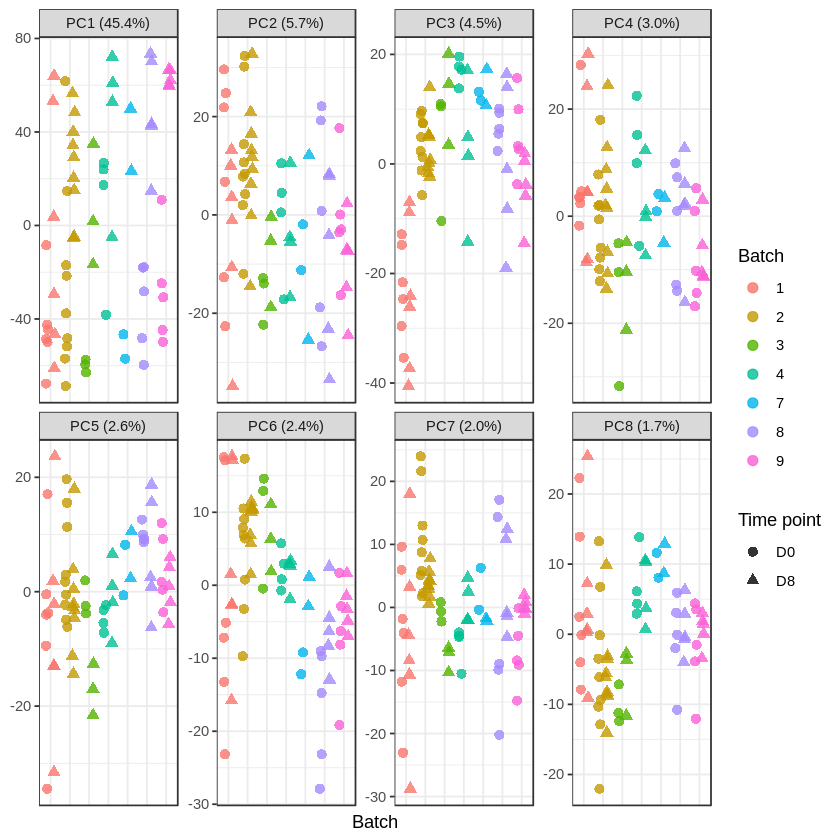

In [609]:
ax_top_pc1

In [611]:
file1 <- '~/Dropbox/tmp/top_pc-telaml1_before.pdf'
file2 <- '~/Dropbox/tmp/top_pc-telaml1_after.pdf'
ggsave(file1, ax_top_pc1, width = 8, height = 4)
ggsave(file2, ax_top_pc2, width = 8, height = 4)

In [204]:
ax_pca1 <- ggplot_pca(
  telaml1[telaml1_ps, ], metadata, cex = 2.5,
  col = 'batch_info', pch = 'class_info'
) +
  labs(col = 'Batch', pch = 'Time point')
ax_pca2 <- ggplot_pca(
  telaml1[selected_ps, ], metadata, cex = 2.5,
  col = 'batch_info', pch = 'class_info'
) +
  labs(col = 'Batch', pch = 'Time point')

In [ ]:
file1 <- '~/Dropbox/tmp/pca-telaml1_before.pdf'
file2 <- '~/Dropbox/tmp/pca-telaml1_after.pdf'
ggsave(file1, ax_pca1, width = 4.5, height = 3.5)
ggsave(file2, ax_pca2, width = 4.5, height = 3.5)

In [205]:
ax_umap1 <- ggplot_umap(
  telaml1[telaml1_ps, ], metadata, cex = 2.5,
  col = 'batch_info', pch = 'class_info'
) +
  labs(col = 'Batch', pch = 'Time point')
ax_umap2 <- ggplot_umap(
  telaml1[selected_ps, ], metadata, cex = 2.5,
  col = 'batch_info', pch = 'class_info'
) +
  labs(col = 'Batch', pch = 'Time point')

In [206]:
file1 <- '~/Dropbox/tmp/umap-telaml1_before.pdf'
file2 <- '~/Dropbox/tmp/umap-telaml1_after.pdf'
ggsave(file1, ax_umap1, width = 4.5, height = 3.5)
ggsave(file2, ax_umap2, width = 4.5, height = 3.5)

# DUX4

In [19]:
PID_DUX4 <- "../tmp/pid-DUX4.txt"
pid_dux4 <- readLines(PID_DUX4)
sid_dux4 <- get_sid(pid_dux4)

# metadata_sid1 <- metadata_sid
# levels(metadata_sid1$subtype) <- c(levels(metadata_sid1$subtype), "DUX4")
# metadata_sid1[sid_dux4, "subtype"] <- "DUX4"

In [21]:
X_normal <- yeoh[, sid_normal]
X_subtype <- yeoh[, sid_dux4]
obj <- predict_pipeline(X_subtype, X_normal, metadata, metadata_pid)

No. of NaN values in log-fc = 0
No. of probesets excluded by expr threshold = 772
No. of features (p-value) = 2564
No. of features (log2-fc) = 679
No. of DE features = 660
No. of final features = 660
No. of samples in centroid = 19
No. of remission samples in training set = 19
Prediction complete!



In [24]:
ax <- plot_boxplot(obj$X_y, p.value = TRUE)
file <- "~/Dropbox/tmp/boxplot-DUX4.pdf"
ggsave(file, ax, width = 9.5, height = 2.5)

Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”

### Compare treatment

In [676]:
add_treatment <- function(obj, metadata_pid) {
  # Adds column - required_treatment: {non-intensive, intensive}
  X_y <- obj$X_y
  treatment <- as.character(metadata_pid[rownames(X_y), 'treatment_processed'])
  names(treatment) <- rownames(X_y)
  treatment <- treatment[!is.na(treatment)] # remove NA values in treatment
  consolidated_treatment <- treatment
  idx <- consolidated_treatment %in% c('HR1', 'HR2')
  consolidated_treatment[idx] <- 'HR'
  consolidated_treatment[!idx] <- 'SR/IR'
  required_treatment <- factor(
    'Non-intensive',
    levels = c('Non-intensive', 'Intensive')
  )
  pid_info <- data.frame(
    treatment,
    consolidated_treatment,
    label = X_y[names(treatment), 'label'],
    required_treatment = required_treatment
  )
  idx_intensive <- pid_info$label == 'Relapse' | pid_info$consolidated_treatment == 'HR'
  pid_info$required_treatment[idx_intensive] <- 'Intensive'
  
  X_y <- X_y[rownames(pid_info), ] # remove patients with treatment NA values
  X_y$treatment <- pid_info$treatment
  X_y$required_treatment <- pid_info$required_treatment # add column to X_y
  
  return(X_y)
}

In [704]:
X_y <- add_treatment(obj, metadata_pid)
head(X_y)

,erm1_ratio2,l2norm_ratio2,angle_LD0_LD8_ratio2,log_mrd_d33,p_d8,p_d33,label,treatment,required_treatment
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
P060,2.2609633,1.3974799,0.5436946,-3.69897,0.3333333,0.4473684,Remission,IR,Non-intensive
P063,0.6173321,0.9174787,0.4324256,-3.00000,0.1052632,0.1973684,Remission,HR1,Intensive
P071,5.0548792,1.4634860,0.6214487,-2.69897,0.5263158,0.5000000,Remission,IR,Non-intensive
P073,2.3434004,1.3656135,0.6268032,-3.30103,0.3859649,0.4210526,Remission,IR,Non-intensive
P076,36.4452859,2.6607007,1.1706164,-3.69897,1.0000000,0.9473684,Remission,IR,Non-intensive
P077,2.5821853,1.4311605,0.6603660,-2.69897,0.4736842,0.4605263,Remission,HR1,Intensive


In [743]:
ax <- plot_boxplot(X_y, group = 'label', fill = 'label')
file <- "~/Dropbox/tmp/boxplot_outcome-DUX4.pdf"
ggsave(file, ax, width = 9.5, height = 2.5)

Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(x1, x2, exact = T):
“cannot compute exact p-value with ties”